<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Introduction

The notebook calculates the partial differential equation of 1st order. For this case, Burgers Equation is being utilized. 

The implementation is done in PyTorch as it provides ease in creating the graph of the network. Furthermore, the implementation is based on the paper "Fourier Neural Operator for Parametric Partial Differential Equation" [Paper Link](https://arxiv.org/pdf/2010.08895.pdf) and the code is mostly taken from the repository that the authors have released. The orginal repository can be accessed via this [Link](https://github.com/zongyi-li/fourier_neural_operator). Whereas, the link to our work is [Link](https://github.com/msaad1311/Julia-Programming).

# Libraries 

The following cell import all the necessary libraries required to carry out the task. The utilities are added into the python script of utilities.py and it is being called in the following cell. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import utilities
import importlib
importlib.reload(utilities)

torch.manual_seed(0)
np.random.seed(0)

# Prelimaries 

The following cell set some prelimaries that will be used throughout the notebook. The description of the variables are mentioned infront of them for the ease of the user. 

In [2]:
ntrain = 1000 # Number of training examples
ntest = 100 # Number of testing examples

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100 # steps set for LR scheduler
gamma = 0.5 # parameter set for LR scheduler

modes = 12 # modes for fourier transform
width = 32 # number of nodes/filters

r = 5
h = int(((421 - 1)/r) + 1)
s = h

# Data Retrival 

The data is saved in a MATLAB file and that is being retrived using the MatReader function developed in the utilities script.

In [4]:
reader = utilities.MatReader('data/piececonst_r421_N1024_smooth1.mat')
x_train = reader.read_field('coeff')[:ntrain,::r,::r][:,:s,:s]
y_train = reader.read_field('sol')[:ntrain,::r,::r][:,:s,:s]

reader.load_file('data/piececonst_r421_N1024_smooth2.mat')
x_test = reader.read_field('coeff')[:ntest,::r,::r][:,:s,:s]
y_test = reader.read_field('sol')[:ntest,::r,::r][:,:s,:s]

x_normalizer = utilities.UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = utilities.UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

In [5]:
print(f'The shape of x_train is {x_train.shape} and the shape of y_train is {y_train.shape}')
print(f'The shape of x_test is {x_test.shape} and the shape of y_test is {y_test.shape}')

The shape of x_train is torch.Size([1000, 85, 85]) and the shape of y_train is torch.Size([1000, 85, 85])
The shape of x_test is torch.Size([100, 85, 85]) and the shape of y_test is torch.Size([100, 85, 85])


The x_train and x_test is being combined with the grid of the of values of the indices

In [6]:
grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s,s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

In [7]:
print(f'The shape of x_train is {x_train.shape} and the shape of y_train is {y_train.shape}')
print(f'The shape of x_test is {x_test.shape} and the shape of y_test is {y_test.shape}')

The shape of x_train is torch.Size([1000, 85, 85, 3]) and the shape of y_train is torch.Size([1000, 85, 85])
The shape of x_test is torch.Size([100, 85, 85, 3]) and the shape of y_test is torch.Size([100, 85, 85])


# Model

The following cell declares the model that is being used. The model is developed using 3 classes. The main class is Net2d which calls the second class which is SimpleBlock2d and that calls SpectralConv2d class.

The following image is the illustration of the model that is being created. 

<img src="final_image.png">


The upper region (Section 1) is implemented in SpectralConv2d. The class first performs fourier transform on the the signal and then after taking the specified modes, returns to the original form. 

The lower region (Section 2) is not implemented separately as it is just a weight matrix. However, the combination of the output after the fourier neural operation and weight matrix is done in the class of the SimpleBlock2d. 

The class Net1d just combines everything together. 

In [3]:
#Complex multiplication
def compl_mul2d(a, b):
    # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
    op = partial(torch.einsum, "bixy,ioxy->boxy")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)


################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.rfft(x, 2, normalized=True, onesided=True)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels,  x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))
        return x

class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(SimpleBlock2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn0(x1 + x2)
        x = F.relu(x)
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn1(x1 + x2)
        x = F.relu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn2(x1 + x2)
        x = F.relu(x)
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn3(x1 + x2)


        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net2d(nn.Module):
    def __init__(self, modes, width):
        super(Net2d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock2d(modes, modes,  width)


    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze()


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

The following cell creates the object train_loader and test_loader that can be used for the training and testing purposes.

In [8]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [9]:
model = Net2d(modes, width).cuda()
print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = utilities.LpLoss(size_average=False)
y_normalizer.cuda()

2368257


## Training Phase

The training of the model is straightforward. The only thing to notice that for the loss function, Lp Loss is being used. However, MSE can also be used as it results in the similar outlook. The implementation of the Lp Loss can be found in the utilities script.

In [10]:
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        # loss = F.mse_loss(model(x).view(-1), y.view(-1), reduction='mean')
        out = model(x)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()


        optimizer.step()
        train_mse += loss.item()

    scheduler.step()
    model.eval()
    abs_err = 0.0
    rel_err = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            out = y_normalizer.decode(model(x))

            rel_err += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_mse/= ntrain
    abs_err /= ntest
    rel_err /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, rel_err)

C:\Users\Saad.LAKES\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
C:\Users\Saad.LAKES\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:602.)


0 8.791005000000013 0.0825868713259697 0.05431708574295044
1 2.7436647999999906 0.04234230333566666 0.032688255906105045
2 2.7310820999999947 0.036724255084991456 0.03264454424381256
3 2.687260600000002 0.033128453344106676 0.05001917958259582
4 2.6857743999999997 0.030573138922452926 0.033396202325820926
5 2.689312600000008 0.02860929161310196 0.027463148534297942
6 2.6862252000000097 0.027992901921272278 0.024920540452003478
7 2.691436500000009 0.02840642434358597 0.027145257294178007
8 2.692419000000001 0.02532982674241066 0.02979120135307312
9 2.6802476000000013 0.03078327912092209 0.029085286259651184
10 2.6882008999999982 0.02690197077393532 0.02350582420825958
11 2.6829309000000023 0.024805624932050706 0.02248555511236191
12 2.687337299999996 0.02434551092982292 0.02989134132862091
13 2.6903668000000067 0.025562329083681105 0.02200817406177521
14 2.687859700000004 0.02549395725131035 0.021739567816257476
15 2.6951767999999987 0.022107514083385467 0.01865007936954498
16 2.6847451

131 2.702768600000013 0.008498608842492103 0.01269064649939537
132 2.6946287000000098 0.008634677782654763 0.011689034551382064
133 2.7107584000000315 0.008245370596647263 0.011843450963497162
134 2.7125679000000105 0.008655358254909516 0.012423769235610962
135 2.6947256000000266 0.009087792307138442 0.012842335999011993
136 2.7021336000000247 0.008535457372665405 0.011730168461799622
137 2.6965254000000414 0.00821169112622738 0.011721656322479249
138 2.700764499999991 0.008136379301548004 0.01231350377202034
139 2.704016299999978 0.008084802061319351 0.01166081428527832
140 2.6957676000000106 0.008627215519547463 0.011705020815134049
141 2.703728099999978 0.009123614117503166 0.012405428439378738
142 2.7028129000000263 0.008293279379606246 0.011701660305261612
143 2.696036100000015 0.008634814217686653 0.012690946608781815
144 2.701914600000009 0.00813311268389225 0.011294579952955247
145 2.7018572000000063 0.008433872491121291 0.011408411711454392
146 2.694266099999993 0.007980173736

259 2.7015205999999807 0.005722495563328266 0.010358922928571702
260 2.70273839999993 0.005827082380652428 0.010222416073083877
261 2.6959900999999036 0.006017812453210354 0.010403582602739334
262 2.722092900000007 0.005754446178674698 0.010350013375282288
263 2.717413599999986 0.006290728367865085 0.010509620755910873
264 2.6974189000000024 0.006259075954556465 0.010158112943172455
265 2.70340699999997 0.0066626926586031915 0.010462197512388229
266 2.7015758000000005 0.006017709538340569 0.01043337807059288
267 2.696842400000037 0.005470190033316612 0.01078966498374939
268 2.702883400000019 0.005842055127024651 0.01044770210981369
269 2.6964179000000286 0.005719048127532005 0.010595803707838058
270 2.7018590999999788 0.006326367989182472 0.010276641100645065
271 2.70551080000007 0.005774598710238933 0.010137851387262344
272 2.6948824999999488 0.00619956711679697 0.010157674849033356
273 2.7021912000000157 0.006013316102325916 0.010628577470779419
274 2.7028387000000293 0.0058940866589

387 2.6761959999998908 0.004849849730730057 0.009818401336669922
388 2.6745370000001003 0.0047219589203596115 0.009836889058351516
389 2.6749024000000645 0.004982870802283287 0.009829322397708893
390 2.6771353000001454 0.004910228304564953 0.009900955259799957
391 2.6745977000000494 0.004914893113076687 0.009807937294244767
392 2.6751162000000477 0.004778803192079067 0.00970895066857338
393 2.6742208999999093 0.004710267290472984 0.009849985986948013
394 2.675491299999976 0.004717401623725891 0.00987127959728241
395 2.6782647999998517 0.004659285381436348 0.009865743517875671
396 2.677806700000019 0.004743246786296368 0.009914864003658295
397 2.6776345999999194 0.00510451078414917 0.009901033639907837
398 2.6773255999999037 0.004840178959071636 0.009726567417383194
399 2.674225299999989 0.004732824549078941 0.009992174208164215
400 2.678392699999904 0.004523723937571049 0.00970894366502762
401 2.6725163000000975 0.004274296581745148 0.009713959842920304
402 2.6764780999999402 0.0043633

## Prediction Phase

The following cell does the testing on the testing data. 

In [11]:
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        out = y_normalizer.decode(model(x))
        pred[index] = out
        index = index + 1

In [12]:
print(f'The shape of the predictions is {pred.shape} and the shape of actual is {y_test.shape}')

The shape of the predictions is torch.Size([100, 85, 85]) and the shape of actual is torch.Size([100, 85, 85])


## Visualization

Once the prediction is being performed it is being plotted against the actual values to visualize the results. The following cell does that and after that MSE is also calculated which is found to be close to zero which shows that the model is able to predict the actual values with great precision.

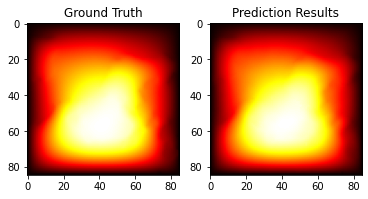

In [18]:
plt.subplot(121)
plt.imshow(y_test[0],cmap='hot')
plt.title('Ground Truth')

plt.subplot(122)
plt.imshow(pred[0],cmap='hot')
plt.title('Prediction Results')
plt.show()

In [24]:
F.mse_loss(pred,y_test)/(y_test.max()-y_test.min())

tensor(3.1795e-07)